# **FOOD IMAGE CERTIFICATION CLASSIFICATION**

---
---
# **IMPORT LIBRARIES**
---
---

---
---
# **DATA GATHERING**
---
---

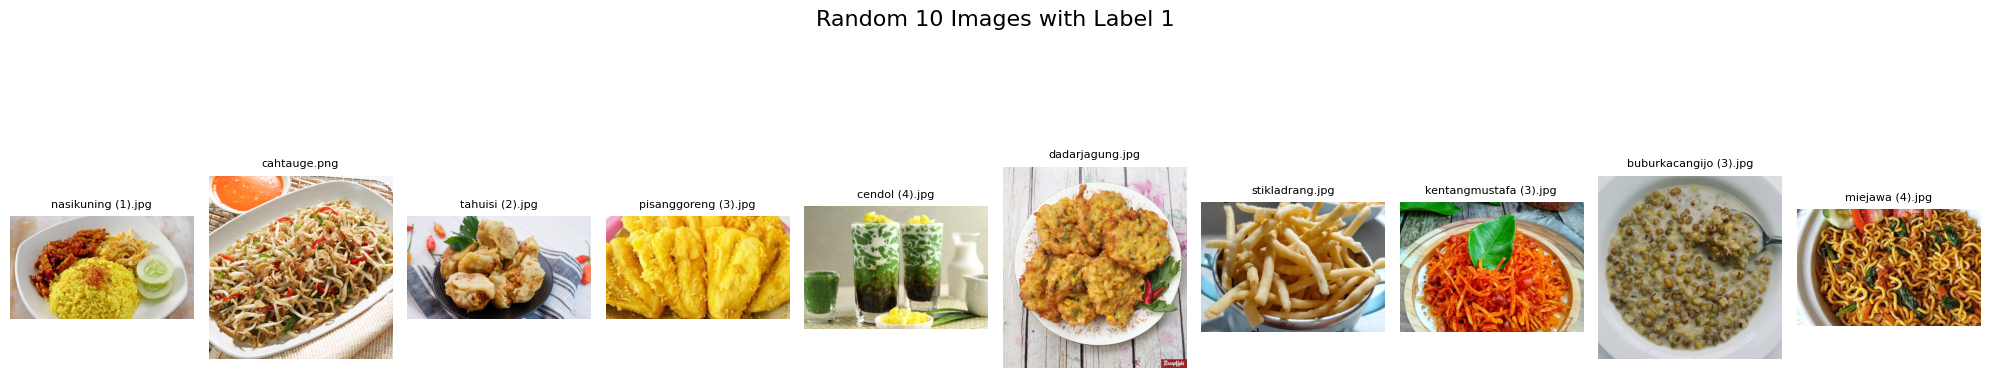

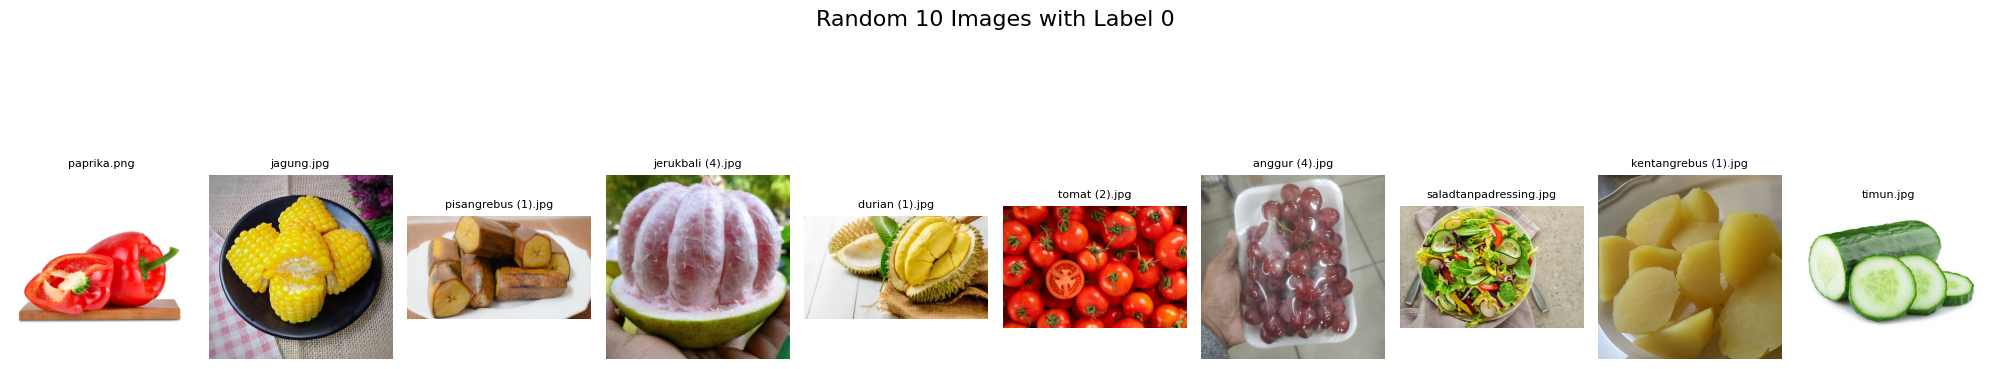

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import random

# Import Dataset
dataset_path = "Dataset/"
splits = ["Train_Nabati", "Val_Nabati", "Test_Nabati"]

# Labeling
categories = {
    "PerluSertifikasi": 1,
    "TidakPerluSertifikasi": 0
}

def load_dataset(dataset_path, splits, categories):
    data = []
    for split in splits:
        for category, label in categories.items():
            folder_path = os.path.join(dataset_path, split, category)
            if not os.path.exists(folder_path):
                print(f"Folder {folder_path} tidak ditemukan, lewati")
                continue
            for file_name in os.listdir(folder_path):
                file_path = os.path.join(folder_path, file_name)
                if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    data.append((file_name, file_path, label))
    return data

# Load Dataset
dataset = load_dataset(dataset_path, splits, categories)

# Separate based on label
label_1_images = [item for item in dataset if item[2] == 1]
label_0_images = [item for item in dataset if item[2] == 0]

# Visualization
label_1_sample = random.sample(label_1_images, min(10, len(label_1_images)))
label_0_sample = random.sample(label_0_images, min(10, len(label_0_images)))

def visualize_images(image_list, label):
    num_images = len(image_list)
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    fig.suptitle(f"Random {num_images} Images with Label {label}", fontsize=16)

    for i in range(num_images):
        file_name, file_path, _ = image_list[i]
        img = cv2.imread(file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].set_title(file_name, fontsize=8)
        axes[i].axis("off")

    plt.tight_layout()
    plt.show()

visualize_images(label_1_sample, 1)
visualize_images(label_0_sample, 0)

# **DATA AUGMENTATION**

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_dir = "Dataset/Train_Nabati"
val_dir = "Dataset/Val_Nabati"
test_dir = "Dataset/Test_Nabati"

IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Data augmentation (for training data)
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Data normalization (for validation and test data)
val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Processing the training and validation data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(128, 128),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

print("\nData Augmentation & Loading Complete!")

Found 680 images belonging to 2 classes.
Found 136 images belonging to 2 classes.
Found 136 images belonging to 2 classes.

Data Augmentation & Loading Complete!


---
---
# **SKENARIO 1: BASE MODEL**
---
---

## **1. MobileNetV2**

### **Train Model**

In [3]:
import scipy
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
import numpy as np

# ==========================================================
# BASE MODEL
# ==========================================================
base_model = MobileNetV2(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False

# ==========================================================
# CUSTOM CLASSIFIER
# ==========================================================
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)

mobilenet_model1 = Model(inputs=base_model.input, outputs=output_layer)

# ==========================================================
# TRAIN HANYA TOP LAYERS
# ==========================================================
mobilenet_model1.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

mobilenet_model1.fit(train_generator, epochs=5, validation_data=val_generator,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)])

d:\1. KULIAH\RESEARCH\env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 672ms/step - accuracy: 0.6403 - loss: 0.7933 - val_accuracy: 0.8235 - val_loss: 0.3443
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 577ms/step - accuracy: 0.8129 - loss: 0.3991 - val_accuracy: 0.7941 - val_loss: 0.4143
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 585ms/step - accuracy: 0.8776 - loss: 0.3351 - val_accuracy: 0.8382 - val_loss: 0.3334
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 569ms/step - accuracy: 0.8621 - loss: 0.2993 - val_accuracy: 0.8603 - val_loss: 0.2972
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 588ms/step - accuracy: 0.8875 - loss: 0.2744 - val_accuracy: 0.8676 - val_loss: 0.3005


In [4]:
# Save MobileNetV2 Model
mobilenet_model1.save("Model/Base/halal_certification_mobilenetv2.h5")
print("\nMobileNetV2 Training Complete!")


MobileNetV2 Training Complete!


### **Test Accuracy**

In [5]:
import numpy as np
import pandas as pd

# Load, compile, evaluate, predict, and save results
mobilenet_model1 = tf.keras.models.load_model("Model/Base/halal_certification_mobilenetv2.h5", compile=False)
mobilenet_model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Evaluate model
test_loss, test_acc = mobilenet_model1.evaluate(test_generator)

# Predict
predictions = mobilenet_model1.predict(test_generator)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Map predictions and actuals
actual_labels = test_generator.classes
filenames = test_generator.filenames
index_to_class = {v: k for k, v in test_generator.class_indices.items()}
actual_names = [index_to_class[i] for i in actual_labels]
predicted_names = [index_to_class[i] for i in predicted_labels]
results = np.where(predicted_labels == actual_labels, "RIGHT", "WRONG")

# Create and save DataFrame
df_mobilenet = pd.DataFrame({
    "filename": filenames,
    "predicted_label": predicted_names,
    "actual_label": actual_names,
    "result": results
}).to_csv("Result/Base/mobilenet_predictions.csv", index=False)

print(f"\nTest Accuracy: {test_acc * 100:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 407ms/step - accuracy: 0.8692 - loss: 0.3628
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 456ms/step

Test Accuracy: 88.24%


## **2. ResNet50**

### **Train Model**

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# ==========================================================
# BASE MODEL
# ==========================================================
base_model = ResNet50(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                      include_top=False,
                      weights='imagenet')
base_model.trainable = False

# ==========================================================
# CUSTOM CLASSIFIER
# ==========================================================
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)

resnet_model1 = Model(inputs=base_model.input, outputs=output_layer)

# ==========================================================
# TRAIN HANYA TOP LAYERS
# ==========================================================
resnet_model1.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

resnet_model1.fit(train_generator, epochs=5, validation_data=val_generator,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)])

Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 27s 974ms/step - accuracy: 0.5180 - loss: 0.7445 - val_accuracy: 0.5735 - val_loss: 0.6857
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 848ms/step - accuracy: 0.5320 - loss: 0.6945 - val_accuracy: 0.5147 - val_loss: 0.6947
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 843ms/step - accuracy: 0.4942 - loss: 0.7209 - val_accuracy: 0.6103 - val_loss: 0.6804
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 856ms/step - accuracy: 0.5173 - loss: 0.7108 - val_accuracy: 0.5000 - val_loss: 0.6836
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 863ms/step - accuracy: 0.5178 - loss: 0.7011 - val_accuracy: 0.6103 - val_loss: 0.6802


In [8]:
# Save ResNet50 Model
resnet_model1.save("Model/Base/halal_certification_resnet50.h5")
print("\nResNet50 Training Complete!")


ResNet50 Training Complete!


### **Test Accuracy**

In [9]:
import numpy as np
import pandas as pd

# Load, compile, evaluate, predict, and save results
resnet_model1 = tf.keras.models.load_model("Model/Base/halal_certification_resnet50.h5", compile=False)
resnet_model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Evaluate Model
test_loss, test_acc = resnet_model1.evaluate(test_generator)

# Predict
predictions = resnet_model1.predict(test_generator)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Map predictions and actuals
actual_labels = test_generator.classes
filenames = test_generator.filenames
index_to_class = {v: k for k, v in test_generator.class_indices.items()}
actual_names = [index_to_class[i] for i in actual_labels]
predicted_names = [index_to_class[i] for i in predicted_labels]
results = np.where(predicted_labels == actual_labels, "RIGHT", "WRONG")

# Create and save DataFrame
df_resnet = pd.DataFrame({
    "filename": filenames,
    "predicted_label": predicted_names,
    "actual_label": actual_names,
    "result": results
}).to_csv("Result/Base/resnet_predictions.csv", index=False)

print(f"\nTest Accuracy: {test_acc * 100:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 454ms/step - accuracy: 0.7411 - loss: 0.6645
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 825ms/step

Test Accuracy: 59.56%


## **3. EfficientNetB0**

### **Train Model**

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ==========================================================
# BASE MODEL
# ==========================================================
base_model = EfficientNetB0(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), 
                             include_top=False, 
                             weights='imagenet')
base_model.trainable = False

# ==========================================================
# CUSTOM CLASSIFIER
# ==========================================================
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)

efficientnet_model1 = Model(inputs=base_model.input, outputs=output_layer)

# ==========================================================
# TRAIN HANYA TOP LAYERS
# ==========================================================
efficientnet_model1.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

efficientnet_model1.fit(train_generator, epochs=10, validation_data=val_generator,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)])

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 783ms/step - accuracy: 0.5064 - loss: 0.7778 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 618ms/step - accuracy: 0.4996 - loss: 0.7154 - val_accuracy: 0.5000 - val_loss: 0.6935
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 627ms/step - accuracy: 0.5337 - loss: 0.6978 - val_accuracy: 0.5000 - val_loss: 0.6935


In [11]:
# Save EfficientNet Model
efficientnet_model1.save("Model/Base/halal_certification_efficientnetb0.h5")
print("\nEfficientNetB0 Training Complete!")


EfficientNetB0 Training Complete!


### **Test Accuracy**

In [12]:
import numpy as np
import pandas as pd

# Load, compile, evaluate, predict, and save results
efficientnet_model1 = tf.keras.models.load_model("Model/Base/halal_certification_efficientnetb0.h5", compile=False)
efficientnet_model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Evaluate model
test_loss, test_acc = efficientnet_model1.evaluate(test_generator)

# Predict
predictions = efficientnet_model1.predict(test_generator)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Map predictions and actuals
actual_labels = test_generator.classes
filenames = test_generator.filenames
index_to_class = {v: k for k, v in test_generator.class_indices.items()}
actual_names = [index_to_class[i] for i in actual_labels]
predicted_names = [index_to_class[i] for i in predicted_labels]
results = np.where(predicted_labels == actual_labels, "RIGHT", "WRONG")

# Create and save DataFrame
df_efficientnet = pd.DataFrame({
    "filename": filenames,
    "predicted_label": predicted_names,
    "actual_label": actual_names,
    "result": results
}).to_csv("Result/Base/efficientnet_predictions.csv", index=False)

print(f"\n📊 Test Accuracy: {test_acc * 100:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 300ms/step - accuracy: 0.7066 - loss: 0.6838


4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/stepWARNING:tensorflow:5 out of the last 11 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000024E0869E320> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 794ms/step

📊 Test Accuracy: 50.00%


## **4. InceptionV3**

### **Train Model**

In [13]:
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ==========================================================
# BASE MODEL
# ==========================================================
base_model = InceptionV3(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False

# ==========================================================
# CUSTOM CLASSIFIER
# ==========================================================
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)

inception_model1 = Model(inputs=base_model.input, outputs=output_layer)

# ==========================================================
# TRAIN HANYA TOP LAYERS
# ==========================================================
inception_model1.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

inception_model1.fit(train_generator, epochs=30, validation_data=val_generator,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
                               ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)])

Epoch 1/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 27s 919ms/step - accuracy: 0.5655 - loss: 1.1541 - val_accuracy: 0.8309 - val_loss: 0.4316 - learning_rate: 0.0010
Epoch 2/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 733ms/step - accuracy: 0.7592 - loss: 0.5065 - val_accuracy: 0.8309 - val_loss: 0.4088 - learning_rate: 0.0010
Epoch 3/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 742ms/step - accuracy: 0.7428 - loss: 0.4811 - val_accuracy: 0.8456 - val_loss: 0.4451 - learning_rate: 0.0010
Epoch 4/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 17s 757ms/step - accuracy: 0.7744 - loss: 0.5064 - val_accuracy: 0.8088 - val_loss: 0.4276 - learning_rate: 0.0010
Epoch 5/30
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 737ms/step - accuracy: 0.7949 - loss: 0.4876 - val_accuracy: 0.8162 - val_loss: 0.4167 - learning_rate: 2.0000e-04


In [14]:
# Save Inception Model
inception_model1.save("Model/Base/halal_certification_inceptionv3.h5")
print("\nInceptionV3 Training Complete!")


InceptionV3 Training Complete!


### **Test Accuracy**

In [15]:
import numpy as np
import pandas as pd

# Load, compile, evaluate, predict, and save results
inception_model1 = tf.keras.models.load_model("Model/Base/halal_certification_inceptionv3.h5")
inception_model1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Evaluate model
test_loss, test_acc = inception_model1.evaluate(test_generator)

# Predict
predictions = inception_model1.predict(test_generator)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Map predictions and actuals
actual_labels = test_generator.classes
filenames = test_generator.filenames
index_to_class = {v: k for k, v in test_generator.class_indices.items()}
actual_names = [index_to_class[i] for i in actual_labels]
predicted_names = [index_to_class[i] for i in predicted_labels]
results = np.where(predicted_labels == actual_labels, "RIGHT", "WRONG")

# Create DataFrame and save to CSV
df_inception = pd.DataFrame({
    "filename": filenames,
    "predicted_label": predicted_names,
    "actual_label": actual_names,
    "result": results
}).to_csv("Result/Base/inception_predictions.csv", index=False)

print(f"\nTest Accuracy: {test_acc * 100:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 367ms/step - accuracy: 0.8363 - loss: 0.3894
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 867ms/step

Test Accuracy: 83.82%


---
---
# **SKENARIO 2: FINE-TUNED**
---
---

## **1. Metode MobileNetV2**

### **Train Model**

In [16]:
import scipy
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import numpy as np

# ==========================================================
# BASE MODEL
# ==========================================================
base_model = MobileNetV2(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False

# ==========================================================
# CUSTOM CLASSIFIER
# ==========================================================
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)

mobilenet_model = Model(inputs=base_model.input, outputs=output_layer)

# ==========================================================
# STAGE 1: TRAIN HANYA TOP LAYERS
# ==========================================================
mobilenet_model.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

mobilenet_model.fit(train_generator, epochs=5, validation_data=val_generator,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)])

# ==========================================================
# STAGE 2: FINE-TUNING SEBAGIAN BASE MODEL
# ==========================================================
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

mobilenet_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

mobilenet_model.fit(train_generator, epochs=10, validation_data=val_generator,
                    callbacks=[
                        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
                    ])

Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 783ms/step - accuracy: 0.6862 - loss: 0.6685 - val_accuracy: 0.8309 - val_loss: 0.4142
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 627ms/step - accuracy: 0.7998 - loss: 0.4365 - val_accuracy: 0.8603 - val_loss: 0.3364
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 630ms/step - accuracy: 0.8816 - loss: 0.2835 - val_accuracy: 0.8309 - val_loss: 0.3428
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 601ms/step - accuracy: 0.8901 - loss: 0.2664 - val_accuracy: 0.8750 - val_loss: 0.3141
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 591ms/step - accuracy: 0.8780 - loss: 0.3025 - val_accuracy: 0.8676 - val_loss: 0.3197
Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 709ms/step - accuracy: 0.8090 - loss: 0.4611 - val_accuracy: 0.8603 - val_loss: 0.3073 - learning_rate: 1.0000e-05
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 603ms/step - accuracy: 0.8151 - loss: 0.3912 - val_accuracy: 0.8676 - val_loss: 0.3029 - learning_rate: 1.0000e-05
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 621m

In [17]:
# Save MobileNetV2 Model
mobilenet_model.save("Model/FineTuned/halal_certification_mobilenetv2.h5")
print("\nMobileNetV2 Fine-Tuning Complete!")


MobileNetV2 Fine-Tuning Complete!


### **Test Accuracy**

In [18]:
import numpy as np
import pandas as pd

# Load, compile, evaluate, predict, and save results
mobilenet_model = tf.keras.models.load_model("Model/FineTuned/halal_certification_mobilenetv2.h5", compile=False)
mobilenet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Evaluate model
test_loss, test_acc = mobilenet_model.evaluate(test_generator)

# Predict
predictions = mobilenet_model.predict(test_generator)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Map predictions and actuals
actual_labels = test_generator.classes
filenames = test_generator.filenames
index_to_class = {v: k for k, v in test_generator.class_indices.items()}
actual_names = [index_to_class[i] for i in actual_labels]
predicted_names = [index_to_class[i] for i in predicted_labels]
results = np.where(predicted_labels == actual_labels, "RIGHT", "WRONG")

# Create and save DataFrame
df_mobilenet = pd.DataFrame({
    "filename": filenames,
    "predicted_label": predicted_names,
    "actual_label": actual_names,
    "result": results
}).to_csv("Result/FineTuned/mobilenet_predictions.csv", index=False)

print(f"\nTest Accuracy: {test_acc * 100:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 251ms/step - accuracy: 0.8912 - loss: 0.2963
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 465ms/step

Test Accuracy: 88.97%


## **2. Metode ResNet50**

### **Train Model**

In [19]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# ==========================================================
# BASE MODEL
# ==========================================================
base_model = ResNet50(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                      include_top=False,
                      weights='imagenet')
base_model.trainable = False

# ==========================================================
# CUSTOM CLASSIFIER
# ==========================================================
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)

resnet_model = Model(inputs=base_model.input, outputs=output_layer)

# ==========================================================
# STAGE 1: TRAIN HANYA TOP LAYERS
# ==========================================================
resnet_model.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

resnet_model.fit(train_generator, epochs=5, validation_data=val_generator,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)])

# ==========================================================
# STAGE 2: FINE-TUNING SEBAGIAN BASE MODEL
# ==========================================================
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False

resnet_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

resnet_model.fit(train_generator, epochs=10, validation_data=val_generator,
                    callbacks=[
                        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
                    ])

Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 28s 988ms/step - accuracy: 0.5028 - loss: 0.7321 - val_accuracy: 0.5000 - val_loss: 0.7094
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 884ms/step - accuracy: 0.5189 - loss: 0.7338 - val_accuracy: 0.5515 - val_loss: 0.6868
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 889ms/step - accuracy: 0.5012 - loss: 0.7184 - val_accuracy: 0.5000 - val_loss: 0.6883
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 902ms/step - accuracy: 0.5087 - loss: 0.7057 - val_accuracy: 0.5515 - val_loss: 0.6827
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 890ms/step - accuracy: 0.4961 - loss: 0.6957 - val_accuracy: 0.6103 - val_loss: 0.6786
Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.4802 - loss: 0.7646 - val_accuracy: 0.6324 - val_loss: 0.6756 - learning_rate: 1.0000e-05
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - accuracy: 0.5655 - loss: 0.6927 - val_accuracy: 0.6103 - val_loss: 0.6734 - learning_rate: 1.0000e-05
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step - 

In [20]:
# Save ResNet50 Model
resnet_model.save("Model/FineTuned/halal_certification_resnet50.h5")
print("\nResNet50 Training & Fine-tuning Complete!")


ResNet50 Training & Fine-tuning Complete!


### **Test Accuracy**

In [21]:
import numpy as np
import pandas as pd

# Load, compile, evaluate, predict, and save results
resnet_model = tf.keras.models.load_model("Model/FineTuned/halal_certification_resnet50.h5", compile=False)
resnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Evaluate Model
test_loss, test_acc = resnet_model.evaluate(test_generator)

# Predict
predictions = resnet_model.predict(test_generator)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Map predictions and actuals
actual_labels = test_generator.classes
filenames = test_generator.filenames
index_to_class = {v: k for k, v in test_generator.class_indices.items()}
actual_names = [index_to_class[i] for i in actual_labels]
predicted_names = [index_to_class[i] for i in predicted_labels]
results = np.where(predicted_labels == actual_labels, "RIGHT", "WRONG")

# Create and save DataFrame
df_resnet = pd.DataFrame({
    "filename": filenames,
    "predicted_label": predicted_names,
    "actual_label": actual_names,
    "result": results
}).to_csv("Result/FineTuned/resnet_predictions.csv", index=False)

print(f"\nTest Accuracy: {test_acc * 100:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 485ms/step - accuracy: 0.7379 - loss: 0.6453
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 842ms/step

Test Accuracy: 55.88%


## **3. Metode EfficientNetB0**

### **Train Model**

In [22]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ==========================================================
# BASE MODEL
# ==========================================================
base_model = EfficientNetB0(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), 
                             include_top=False, 
                             weights='imagenet')
base_model.trainable = False

# ==========================================================
# CUSTOM CLASSIFIER
# ==========================================================
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)

efficientnet_model = Model(inputs=base_model.input, outputs=output_layer)

# ==========================================================
# STAGE 1: TRAIN HANYA TOP LAYERS
# ==========================================================
efficientnet_model.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

efficientnet_model.fit(train_generator, epochs=10, validation_data=val_generator,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)])

# ==========================================================
# STAGE 2: FINE-TUNING SEBAGIAN BASE MODEL
# ==========================================================
base_model.trainable = True
for layer in base_model.layers[:-30]:
    layer.trainable = False 

efficientnet_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

efficientnet_model.fit(train_generator, epochs=15, validation_data=val_generator,
                    callbacks=[
                        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
                    ])

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 28s 870ms/step - accuracy: 0.5107 - loss: 0.7280 - val_accuracy: 0.5000 - val_loss: 0.7093
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 688ms/step - accuracy: 0.5041 - loss: 0.7275 - val_accuracy: 0.5000 - val_loss: 0.6988
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 627ms/step - accuracy: 0.5516 - loss: 0.6946 - val_accuracy: 0.5000 - val_loss: 0.7138
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 613ms/step - accuracy: 0.5067 - loss: 0.7016 - val_accuracy: 0.5000 - val_loss: 0.6968
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 644ms/step - accuracy: 0.5223 - loss: 0.6947 - val_accuracy: 0.5000 - val_loss: 0.6938
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 624ms/step - accuracy: 0.5233 - loss: 0.6919 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 614ms/step - accuracy: 0.4841 - loss: 0.6980 - val_accuracy: 0.5000 - val_loss: 0.6937
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 608ms/step - accuracy: 0.4531 - loss: 0.6966 - val_accu

In [23]:
# Save EfficientNet Model
efficientnet_model.save("Model/FineTuned/halal_certification_efficientnetb0.h5")
print("\nEfficientNetB0 Training & Fine-tuning Complete!")


EfficientNetB0 Training & Fine-tuning Complete!


### **Test Accuracy**

In [24]:
import numpy as np
import pandas as pd

# Load, compile, evaluate, predict, and save results
efficientnet_model = tf.keras.models.load_model("Model/FineTuned/halal_certification_efficientnetb0.h5", compile=False)
efficientnet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Evaluate model
test_loss, test_acc = efficientnet_model.evaluate(test_generator)

# Predict
predictions = efficientnet_model.predict(test_generator)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Map predictions and actuals
actual_labels = test_generator.classes
filenames = test_generator.filenames
index_to_class = {v: k for k, v in test_generator.class_indices.items()}
actual_names = [index_to_class[i] for i in actual_labels]
predicted_names = [index_to_class[i] for i in predicted_labels]
results = np.where(predicted_labels == actual_labels, "RIGHT", "WRONG")

# Create and save DataFrame
df_efficientnet = pd.DataFrame({
    "filename": filenames,
    "predicted_label": predicted_names,
    "actual_label": actual_names,
    "result": results
}).to_csv("Result/FineTuned/efficientnet_predictions.csv", index=False)

print(f"\n📊 Test Accuracy: {test_acc * 100:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 292ms/step - accuracy: 0.7066 - loss: 0.6925
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 740ms/step

📊 Test Accuracy: 50.00%


## **4. Metode InceptionV3**

### **Train Model**

In [25]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# ==========================================================
# BASE MODEL
# ==========================================================
base_model = InceptionV3(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), 
                         include_top=False, 
                         weights='imagenet')
base_model.trainable = False

# ==========================================================
# CUSTOM CLASSIFIER
# ==========================================================
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output_layer = Dense(1, activation='sigmoid')(x)

inception_model = Model(inputs=base_model.input, outputs=output_layer)

# ==========================================================
# STAGE 1: TRAIN TOP LAYERS SAJA
# ==========================================================
inception_model.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

inception_model.fit(train_generator,
                    epochs=10,
                    validation_data=val_generator,
                    callbacks=[
                        EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
                    ])

# ==========================================================
# STAGE 2: FINE-TUNING SEBAGIAN BASE MODEL
# ==========================================================
base_model.trainable = True

for layer in base_model.layers[:-50]:
    layer.trainable = False

inception_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

inception_model.fit(train_generator,
                    epochs=15,
                    validation_data=val_generator,
                    callbacks=[
                        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
                    ])

Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 23s 816ms/step - accuracy: 0.6030 - loss: 1.1197 - val_accuracy: 0.7426 - val_loss: 0.4841
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 656ms/step - accuracy: 0.7370 - loss: 0.5830 - val_accuracy: 0.8162 - val_loss: 0.4257
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 667ms/step - accuracy: 0.7774 - loss: 0.5019 - val_accuracy: 0.7868 - val_loss: 0.4666
Epoch 4/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 684ms/step - accuracy: 0.7424 - loss: 0.5001 - val_accuracy: 0.8235 - val_loss: 0.4166
Epoch 5/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 705ms/step - accuracy: 0.8013 - loss: 0.4369 - val_accuracy: 0.8309 - val_loss: 0.3984
Epoch 6/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 720ms/step - accuracy: 0.7872 - loss: 0.4666 - val_accuracy: 0.8162 - val_loss: 0.4399
Epoch 7/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 735ms/step - accuracy: 0.7977 - loss: 0.4248 - val_accuracy: 0.8382 - val_loss: 0.3777
Epoch 8/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 16s 740ms/step - accuracy: 0.8101 - loss: 0.4500 - val_accu

In [26]:
inception_model.save("Model/FineTuned/halal_certification_inceptionv3.h5")
print("\nInceptionV3 Fine-Tuned Training Complete!")


InceptionV3 Fine-Tuned Training Complete!


### **Test Accuracy**

In [27]:
import numpy as np
import pandas as pd

# Load, compile, evaluate, predict, and save results
inception_model = tf.keras.models.load_model("Model/FineTuned/halal_certification_inceptionv3.h5")
inception_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Evaluate model
test_loss, test_acc = inception_model.evaluate(test_generator)

# Predict
predictions = inception_model.predict(test_generator)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Map predictions and actuals
actual_labels = test_generator.classes
filenames = test_generator.filenames
index_to_class = {v: k for k, v in test_generator.class_indices.items()}
actual_names = [index_to_class[i] for i in actual_labels]
predicted_names = [index_to_class[i] for i in predicted_labels]
results = np.where(predicted_labels == actual_labels, "RIGHT", "WRONG")

# Create DataFrame and save to CSV
df_inception = pd.DataFrame({
    "filename": filenames,
    "predicted_label": predicted_names,
    "actual_label": actual_names,
    "result": results
}).to_csv("Result/FineTuned/inception_predictions.csv", index=False)

print(f"\nTest Accuracy: {test_acc * 100:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 425ms/step - accuracy: 0.9071 - loss: 0.3154
5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step  

Test Accuracy: 89.71%


---
---
# **SKENARIO 3: HYPERPARAMETER TUNNING**
---
---

## **1. Metode MobileNetV2**

In [29]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Grid hyperparameter
dense_units_list = [128, 256, 512]
dropout_list = [0.4, 0.5, 0.6]
optimizer_list = ['adam', 'rmsprop']
unfreeze_layer_list = [-20, -30, -40]

IMG_SIZE = (128, 128)
lr2 = 1e-5

best_val_acc = 0
best_config = {}

for dense_units in dense_units_list:
    for dropout in dropout_list:
        for opt_name in optimizer_list:
            for unf in unfreeze_layer_list:
                
                print(f">>> Training with: dense={dense_units}, dropout={dropout}, opt={opt_name}, lr2={lr2}, unf={unf}")
                
                base_model = MobileNetV2(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                                         include_top=False, weights='imagenet')
                base_model.trainable = False

                x = base_model.output
                x = GlobalAveragePooling2D()(x)
                x = Dense(dense_units, activation='relu')(x)
                x = Dropout(dropout)(x)
                out = Dense(1, activation='sigmoid')(x)
                model = Model(inputs=base_model.input, outputs=out)

                model.compile(optimizer=opt_name,
                              loss='binary_crossentropy',
                              metrics=['accuracy'])

                model.fit(train_generator,
                          epochs=5,
                          validation_data=val_generator,
                          callbacks=[EarlyStopping(patience=2, restore_best_weights=True)],
                          verbose=0)

                # Fine-tuning
                base_model.trainable = True
                for layer in base_model.layers[:unf]:
                    layer.trainable = False
                
                if opt_name == 'adam':
                    optimizer = Adam(learning_rate=lr2)
                else:
                    optimizer = RMSprop(learning_rate=lr2)

                model.compile(optimizer=optimizer,
                              loss='binary_crossentropy',
                              metrics=['accuracy'])

                history = model.fit(train_generator,
                                    epochs=5,
                                    validation_data=val_generator,
                                    callbacks=[EarlyStopping(patience=2, restore_best_weights=True)],
                                    verbose=0)
                
                val_acc = history.history['val_accuracy'][-1]
                
                if val_acc > best_val_acc:
                    best_val_acc = val_acc
                    best_config = {
                        'dense_units': dense_units,
                        'dropout': dropout,
                        'optimizer': opt_name,
                        'lr_stage2': lr2,
                        'unfreeze': unf
                    }

print(f"\n✅ Best Config: {best_config}, Val Acc: {best_val_acc:.4f}")


>>> Training with: dense=128, dropout=0.4, opt=adam, lr2=1e-05, unf=-20
>>> Training with: dense=128, dropout=0.4, opt=adam, lr2=1e-05, unf=-30
>>> Training with: dense=128, dropout=0.4, opt=adam, lr2=1e-05, unf=-40
>>> Training with: dense=128, dropout=0.4, opt=rmsprop, lr2=1e-05, unf=-20
>>> Training with: dense=128, dropout=0.4, opt=rmsprop, lr2=1e-05, unf=-30
>>> Training with: dense=128, dropout=0.4, opt=rmsprop, lr2=1e-05, unf=-40
>>> Training with: dense=128, dropout=0.5, opt=adam, lr2=1e-05, unf=-20
>>> Training with: dense=128, dropout=0.5, opt=adam, lr2=1e-05, unf=-30
>>> Training with: dense=128, dropout=0.5, opt=adam, lr2=1e-05, unf=-40
>>> Training with: dense=128, dropout=0.5, opt=rmsprop, lr2=1e-05, unf=-20
>>> Training with: dense=128, dropout=0.5, opt=rmsprop, lr2=1e-05, unf=-30
>>> Training with: dense=128, dropout=0.5, opt=rmsprop, lr2=1e-05, unf=-40
>>> Training with: dense=128, dropout=0.6, opt=adam, lr2=1e-05, unf=-20
>>> Training with: dense=128, dropout=0.6, opt

In [30]:
import scipy
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import numpy as np

# ==========================================================
# BASE MODEL
# ==========================================================
base_model = MobileNetV2(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
                         include_top=False,
                         weights='imagenet')
base_model.trainable = False

# ==========================================================
# CUSTOM CLASSIFIER
# ==========================================================
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
output_layer = Dense(1, activation='sigmoid')(x)

mobilenet_model = Model(inputs=base_model.input, outputs=output_layer)

# ==========================================================
# STAGE 1: TRAIN HANYA TOP LAYERS
# ==========================================================
mobilenet_model.compile(optimizer='rmsprop',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

mobilenet_model.fit(train_generator, epochs=5, validation_data=val_generator,
                    callbacks=[EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)])

# ==========================================================
# STAGE 2: FINE-TUNING SEBAGIAN BASE MODEL
# ==========================================================
base_model.trainable = True
for layer in base_model.layers[:-40]:
    layer.trainable = False

mobilenet_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

mobilenet_model.fit(train_generator, epochs=10, validation_data=val_generator,
                    callbacks=[
                        EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
                        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)
                    ])

Epoch 1/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 751ms/step - accuracy: 0.6077 - loss: 0.9795 - val_accuracy: 0.8015 - val_loss: 0.3927
Epoch 2/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 656ms/step - accuracy: 0.8238 - loss: 0.3904 - val_accuracy: 0.8162 - val_loss: 0.3280
Epoch 3/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 608ms/step - accuracy: 0.8384 - loss: 0.3725 - val_accuracy: 0.8162 - val_loss: 0.3181
Epoch 4/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 612ms/step - accuracy: 0.8794 - loss: 0.3049 - val_accuracy: 0.8382 - val_loss: 0.3230
Epoch 5/5
22/22 ━━━━━━━━━━━━━━━━━━━━ 13s 613ms/step - accuracy: 0.8715 - loss: 0.2978 - val_accuracy: 0.8309 - val_loss: 0.3515
Epoch 1/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 25s 760ms/step - accuracy: 0.6888 - loss: 0.5963 - val_accuracy: 0.8162 - val_loss: 0.3117 - learning_rate: 1.0000e-05
Epoch 2/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 647ms/step - accuracy: 0.7879 - loss: 0.4440 - val_accuracy: 0.8162 - val_loss: 0.3122 - learning_rate: 1.0000e-05
Epoch 3/10
22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 624m

In [31]:
# Save MobileNetV2 Model
mobilenet_model.save("Model/Hyperparameter/halal_certification_mobilenetv2.h5")
print("\nMobileNetV2 Hyperparameter Complete!")


MobileNetV2 Hyperparameter Complete!


In [32]:
import numpy as np
import pandas as pd

# Load, compile, evaluate, predict, and save results
mobilenet_model = tf.keras.models.load_model("Model/Hyperparameter/halal_certification_mobilenetv2.h5", compile=False)
mobilenet_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Evaluate model
test_loss, test_acc = mobilenet_model.evaluate(test_generator)

# Predict
predictions = mobilenet_model.predict(test_generator)
predicted_labels = (predictions > 0.5).astype(int).flatten()

# Map predictions and actuals
actual_labels = test_generator.classes
filenames = test_generator.filenames
index_to_class = {v: k for k, v in test_generator.class_indices.items()}
actual_names = [index_to_class[i] for i in actual_labels]
predicted_names = [index_to_class[i] for i in predicted_labels]
results = np.where(predicted_labels == actual_labels, "RIGHT", "WRONG")

# Create and save DataFrame
df_mobilenet = pd.DataFrame({
    "filename": filenames,
    "predicted_label": predicted_names,
    "actual_label": actual_names,
    "result": results
}).to_csv("Result/Hyperparameter/mobilenet_predictions.csv", index=False)

print(f"\nTest Accuracy: {test_acc * 100:.2f}%")

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 262ms/step - accuracy: 0.8837 - loss: 0.2706
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 490ms/step

Test Accuracy: 87.50%


---
---
# **(OPTIONAL) CHECK ERROR PICTURE(S)**
---
---

In [ ]:
import os
import cv2
    
dataset_dirs = [
    "Dataset/Train_Nabati/PerluSertifikasi",
    "Dataset/Train_Nabati/TidakPerluSertifikasi",
    "Dataset/Val_Nabati/PerluSertifikasi",
    "Dataset/Val_Nabati/TidakPerluSertifikasi",
    "Dataset/Test_Nabati/PerluSertifikasi",
    "Dataset/Test_Nabati/TidakPerluSertifikasi"
]

broken_images = []

for folder in dataset_dirs:
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            try:
                img = cv2.imread(img_path)
                if img is None:
                    print(f"❌ Could not read (None): {img_path}")
                    broken_images.append(img_path)
            except Exception as e:
                print(f"⚠️ Error loading {img_path}: {e}")
                broken_images.append(img_path)

if broken_images:
    print("\n🧯 Broken or unreadable images found:")
    for img in broken_images:
        print(f" - {img}")
else:
    print("\n✅ All images loaded successfully!")